# rACS in Real-Multiplexer

In [1]:
# Logger
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import local paths
import sys, os
sys.path.append(os.path.abspath('../../..'))
sys.path.append(os.path.abspath('../../../../openai-envs'))

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from lcs.representations.RealValueEncoder import RealValueEncoder
from lcs.agents.racs import RACS, Configuration

# Load OpenAI environments
import gym
import gym_multiplexer

## Real-Multiplexer
In 3-bit multiplexer first bit is responsible for addressing the correct answer.

> For testing purposes the last bit is used as a flag indicating if the action chosen by the algorithm was correct. The environment always introduces it with 0. It's value is changed to 1 if the action was chosen correctly.

In [2]:
# Environment initialization
rmpx = gym.make('real-multiplexer-3bit-v0')

rMPX acts like a normal MPX with the difference that instead on boolean values floating numbers within range `[0,1]` are used. Environment used internal threshold to transform them into boolean values (`threshold=0.5` is used as default).

In [3]:
state = rmpx.reset()
state

[0.3725874283604559, 0.9052590538764941, 0.15552403628446665, 0]

Which corresponds to the following binary MPX:

In [4]:
threshold = 0.5  # secret knowledge
binary_state = map(lambda x: 1 if x > threshold else 0, state)

list(binary_state)

[0, 1, 0, 0]

Depending on the MPX size we have some actions to be executed. In 3-bit variant first bit (_address bit_) points to the correct answer (two possible values).

In [5]:
rmpx.action_space.n

2

We can also investigate the properties of a single observation (like vector dimension, lower and upper bound of each attribute).

In [6]:
print(f"Observation shape: {rmpx.observation_space.shape}")
print(f"Upper bounds: {rmpx.observation_space.low}")
print(f"Lower bounds: {rmpx.observation_space.high}")

Observation shape: (4,)
Upper bounds: [0. 0. 0. 0.]
Lower bounds: [1. 1. 1. 1.]


## rACS

- write abount _encoders_

In [7]:
def encode(bits, val):
    return int(RealValueEncoder(bits).encode(val))


r = np.arange(0, 1.1, .1)

df = pd.DataFrame(r, columns=['Perception'])

for bit in [1, 2, 3, 4, 5, 6, 7]:
    df[f'{bit}-bit'] = df.apply(lambda row: encode(bit, row['Perception']), axis=1)

df.set_index('Perception', inplace=True)
df

,1-bit,2-bit,3-bit,4-bit,5-bit,6-bit,7-bit
Perception,,,,,,,
0.0,0,0,0,0,0,0,0
0.1,0,0,0,1,3,6,12
0.2,0,0,1,3,6,12,25
0.3,0,1,2,4,9,19,38
0.4,0,1,3,6,12,25,51
0.5,1,2,4,8,16,32,64
0.6,1,2,4,9,19,38,76
0.7,1,2,5,11,22,44,89
0.8,1,3,6,12,25,51,102


## Experiment
In the experiment each attribute range will be represented as an _unorded bounded tuple_ with desired encoding resolution.

In [8]:
# Define function for fetching interesing metrics
def rmpx_metrics(population, environment):
    return {
        'population': len(population),
        'numerosity': sum(cl.num for cl in population),
        'reliable': len([cl for cl in population if cl.is_reliable()]),
    }

Define a function for executing experiments

In [9]:
def perform_experiment(env, encoder_bits, trials):
    # create configuration
    cfg = Configuration(env.observation_space.shape[0], env.action_space.n,
                    encoder=RealValueEncoder(encoder_bits),
                    metrics_trial_frequency=5,
                    user_metrics_collector_fcn=rmpx_metrics,
                    epsilon=1.0,  # no biased exploration
                    do_ga=True,
                    theta_r=0.9,  # reliablity threshold
                    theta_i=0.2,  # inadequacy threshold
                    theta_ga=100,
                    cover_noise=0,
                    mutation_noise=0.25,
                    chi=1.0,  # cross-over probability
                    mu=0.1)  # mutation probability
    
    # create agent
    agent = RACS(cfg)
    
    # run computations
    population, metrics = agent.explore_exploit(env, trials)
    
    return population, metrics

## Data visualization

In [10]:
def parse_metrics(metrics):
    lst = [[d['trial'], d['reward'], d['population'], d['reliable']] for d in metrics]

    df = pd.DataFrame(lst, columns=['trial', 'reward', 'population', 'reliable'])
    df = df.set_index('trial')
    df['mode'] = df.index.map(lambda t: "explore" if t % 2 == 0 else "exploit")

    return df

In [11]:
def plot_results(metrics, env, encoder_bits):
    # parse metrics into data frame
    df = parse_metrics(metrics)
    
    # separate explore/exploit data
    explore_df = df[df['mode'] == 'explore']
    exploit_df = df[df['mode'] == 'exploit']
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.suptitle(f"{env.env.spec.id}, ubr encoder bits: {encoder_bits}", fontsize=14)
    
    # plot 1 - average reward
    explore_df['reward'].rolling(window=50).mean().plot(label='explore', ax=ax1)
    exploit_df['reward'].rolling(window=50).mean().plot(label='exploit', ax=ax1)

    ax1.axhline(y=500, color='black', linestyle='--', linewidth=1)
    ax1.axhline(y=1000, color='black', linestyle='--', linewidth=1)

    # ax1.annotate('maximum reward', xy=(500, 950), xycoords='data')
        
    ax1.set_title('Average reward')
    ax1.set_xlabel('Trial')
    ax1.set_ylabel('Average reward')
    ax1.set_ylim(400, 1100)
    ax1.legend()
    
    # plot 2 - number of classifiers
    df['population'].plot(label='population', ax=ax2)
    df['reliable'].plot(label='reliable', ax=ax2)
    
    ax2.set_title("Classifiers evolution")
    ax2.set_xlabel('Trial')
    ax2.set_ylabel('# Classifiers')
    ax2.legend()
    
    f.savefig("foo.pdf", bbox_inches='tight')

## Experiments

In [12]:
def evaluate(rmpx, encoder_bits, trials=10_000):
    population, metrics = perform_experiment(rmpx, encoder_bits=encoder_bits, trials=trials)
    plot_results(metrics, rmpx, encoder_bits)
    
    # sort classifiers in population according to action
    population = sorted(population, key=lambda cl: cl.action)

    return population, metrics

### 3-bit rMPX

In [13]:
rmpx3 = gym.make('real-multiplexer-3bit-v0')

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1, 'reward': 0, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 5000, 'steps_in_trial': 1, 'reward': 1000, 'population': 13, 'numerosity': 154, 'reliable': 12}


CPU times: user 8.09 s, sys: 97.3 ms, total: 8.18 s
Wall time: 7.94 s


([O.|.O|OO|OO	0	OO|OO|OO|OO x 20 fitness: 0.00,
  O.|O.|.O|O.	0	OO|OO|OO|.O x 20 fitness: 500.00,
  OO|O.|O.|O.	0	OO|OO|OO|.O x 4 fitness: 625.00,
  .O|OO|.O|OO	0	OO|OO|OO|OO x 20 fitness: 0.00,
  .O|OO|O.|O.	0	OO|OO|OO|.O x 17 fitness: 625.00,
  O.|O.|OO|OO	1	OO|OO|OO|OO x 4 fitness: 0.00,
  OO|O.|O.|OO	1	OO|OO|OO|OO x 15 fitness: 0.00,
  O.|.O|OO|O.	1	OO|OO|OO|.O x 20 fitness: 625.00,
  .O|OO|O.|OO	1	OO|OO|OO|OO x 7 fitness: 0.00,
  .O|OO|.O|O.	1	OO|OO|OO|.O x 18 fitness: 625.00,
  OO|O.|OO|OO	1	OO|OO|OO|OO x 1 fitness: 116.34,
  OO|O.|OO|O.	1	OO|OO|OO|.O x 1 fitness: 84.32],
 [{'trial': 0,
   'steps_in_trial': 1,
   'reward': 0,
   'population': 1,
   'numerosity': 1,
   'reliable': 0},
  {'trial': 5,
   'steps_in_trial': 1,
   'reward': 0,
   'population': 2,
   'numerosity': 2,
   'reliable': 0},
  {'trial': 10,
   'steps_in_trial': 1,
   'reward': 1000,
   'population': 3,
   'numerosity': 3,
   'reliable': 0},
  {'trial': 15,
   'steps_in_trial': 1,
   'reward': 0,
   'populatio

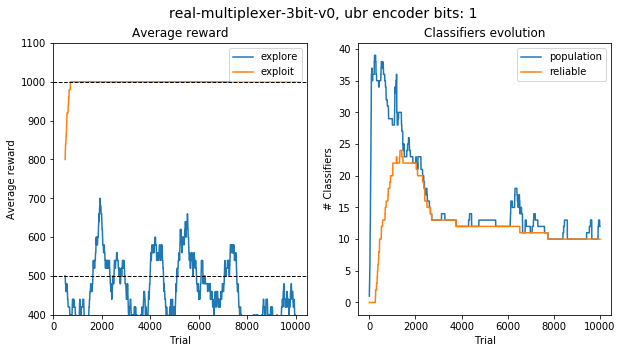

In [14]:
%%time
evaluate(rmpx3, encoder_bits=1, trials=10_000)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1, 'reward': 1000, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 5000, 'steps_in_trial': 1, 'reward': 0, 'population': 92, 'numerosity': 574, 'reliable': 47}
INFO:lcs.agents.Agent:{'trial': 10000, 'steps_in_trial': 1, 'reward': 0, 'population': 51, 'numerosity': 538, 'reliable': 50}


CPU times: user 33.2 s, sys: 117 ms, total: 33.4 s
Wall time: 33.2 s


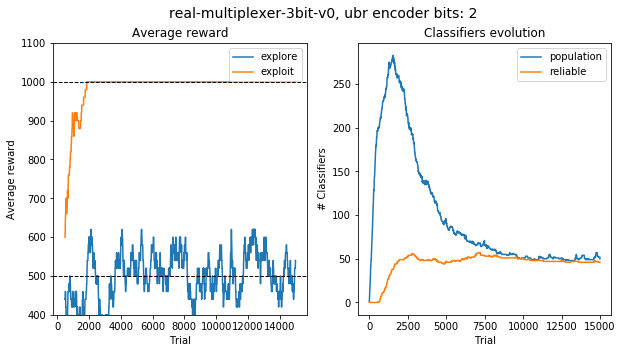

In [15]:
%%time
pop3, m3 = evaluate(rmpx3, encoder_bits=2, trials=15_000)

In [16]:
from itertools import groupby

rel = [cl for cl in pop3 if cl.is_reliable()]

for k, g in groupby(rel, key=lambda cl: cl.action):
    niche = list(g)
    print(f'\nAction: {k}, classifiers: {len(niche)}')
    for cl in sorted(niche, key=lambda cl: -cl.fitness):
        print(f'{cl}')


Action: 0, classifiers: 30
OOOO|OO..|OO..|O...	0	OOOO|OOOO|OOOO|...O x 6 fitness: 551.37
OOOO|OO..|O...|O...	0	OOOO|OOOO|OOOO|...O x 2 fitness: 500.00
O...|OO..|OOOO|O...	0	OOOO|OOOO|OOOO|...O x 16 fitness: 499.73
...O|OOOO|O...|O...	0	OOOO|OOOO|OOOO|...O x 15 fitness: 437.50
OOOO|.O..|.O..|O...	0	OOOO|OOOO|OOOO|...O x 1 fitness: 437.50
...O|OOOO|.O..|O...	0	OOOO|OOOO|OOOO|...O x 18 fitness: 437.50
..O.|OOOO|.O..|O...	0	OOOO|OOOO|OOOO|...O x 13 fitness: 437.50
..O.|OOOO|O...|O...	0	OOOO|OOOO|OOOO|...O x 15 fitness: 410.79
.O..|.O..|.OOO|O...	0	OOOO|OOOO|OOOO|...O x 16 fitness: 370.75
.O..|OO..|...O|O...	0	OOOO|OOOO|OOOO|...O x 4 fitness: 312.26
OO..|O...|...O|O...	0	OOOO|OOOO|OOOO|...O x 1 fitness: 311.86
O...|.O..|...O|O...	0	OOOO|OOOO|OOOO|...O x 1 fitness: 248.98
...O|..O.|.O..|O...	0	OOOO|OOOO|OOOO|...O x 1 fitness: 248.69
..O.|...O|.O..|O...	0	OOOO|OOOO|OOOO|...O x 1 fitness: 248.16
..O.|...O|O...|O...	0	OOOO|OOOO|OOOO|...O x 4 fitness: 248.02
.O..|.O..|..O.|O...	0	OOOO|OOOO|OOOO

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1, 'reward': 1000, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 5000, 'steps_in_trial': 1, 'reward': 0, 'population': 1568, 'numerosity': 2901, 'reliable': 32}
INFO:lcs.agents.Agent:{'trial': 10000, 'steps_in_trial': 1, 'reward': 1000, 'population': 1509, 'numerosity': 3589, 'reliable': 103}
INFO:lcs.agents.Agent:{'trial': 15000, 'steps_in_trial': 1, 'reward': 0, 'population': 1466, 'numerosity': 4259, 'reliable': 113}


CPU times: user 8min 55s, sys: 4.84 s, total: 9min
Wall time: 9min 40s


([.......O|.O......|....O...|OOOOOOOO	0	OOOOOOOO|OOOOOOOO|OOOOOOOO|OOOOOOOO x 2 fitness: 40.08,
  ....O...|...O....|.......O|OOOOOOOO	0	OOOOOOOO|OOOOOOOO|OOOOOOOO|OOOOOOOO x 1 fitness: 55.76,
  ......O.|OOOOOOOO|OOOOOOOO|.O......	0	OOOOOOOO|OOOOOOOO|OOOOOOOO|.......O x 1 fitness: 169.86,
  ...O....|..O.....|....O...|.OOO....	0	OOOOOOOO|OOOOOOOO|OOOOOOOO|.....OOO x 2 fitness: 67.48,
  ...O....|..O.....|OOOOOOOO|.OOO....	0	OOOOOOOO|OOOOOOOO|OOOOOOOO|.....OOO x 1 fitness: 286.27,
  O.......|...O....|......O.|.OOO....	0	OOOOOOOO|OOOOOOOO|OOOOOOOO|.....OOO x 1 fitness: 80.08,
  O.......|...O....|OOOOOOOO|.OOO....	0	OOOOOOOO|OOOOOOOO|OOOOOOOO|.....OOO x 1 fitness: 235.19,
  OOOOOOOO|...O....|.O......|.OOO....	0	OOOOOOOO|OOOOOOOO|OOOOOOOO|.....OOO x 1 fitness: 266.06,
  ......O.|OOOOOOOO|.......O|OOOOOOOO	0	OOOOOOOO|OOOOOOOO|OOOOOOOO|OOOOOOOO x 15 fitness: 5.81,
  ..O.....|...O....|OOOOOOOO|.OOO....	0	OOOOOOOO|OOOOOOOO|OOOOOOOO|.....OOO x 1 fitness: 293.39,
  ......O.|OOOOOOOO|......O.|OOOOOO

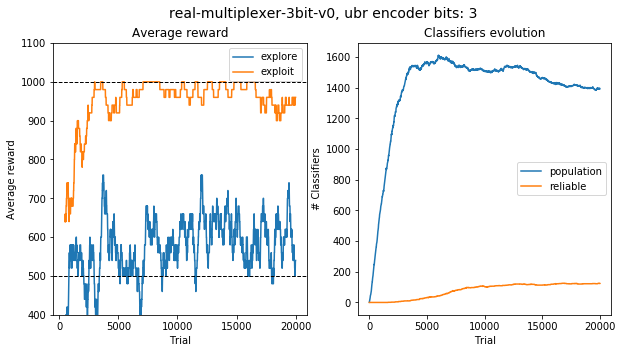

In [17]:
%%time
evaluate(rmpx, encoder_bits=3, trials=20_000)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1, 'reward': 0, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 5000, 'steps_in_trial': 1, 'reward': 0, 'population': 3567, 'numerosity': 4761, 'reliable': 4}
INFO:lcs.agents.Agent:{'trial': 10000, 'steps_in_trial': 1, 'reward': 0, 'population': 4611, 'numerosity': 7101, 'reliable': 23}
INFO:lcs.agents.Agent:{'trial': 15000, 'steps_in_trial': 1, 'reward': 1000, 'population': 5443, 'numerosity': 8996, 'reliable': 41}
INFO:lcs.agents.Agent:{'trial': 20000, 'steps_in_trial': 1, 'reward': 1000, 'population': 6079, 'numerosity': 10715, 'reliable': 49}
INFO:lcs.agents.Agent:{'trial': 25000, 'steps_in_trial': 1, 'reward': 1000, 'population': 6602, 'numerosity': 12052, 'reliable': 71}
INFO:lcs.agents.Agent:{'trial': 30000, 'steps_in_trial': 1, 'reward': 1000, 'population': 7060, 'numerosity': 13335, 'reliable': 92}
INFO:lcs.agents.Agent:{'trial': 35000, 'steps_in_trial': 1, 'reward': 0, 'population': 7437, 'n

([OOOOOOOOOO|OOOOOOOOOO|..O.......|.OO.......	0	OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO|........OO x 1 fitness: 123.95,
  OOOOOOOOOO|OOOOOOOOOO|....O.....|.OO.......	0	OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO|........OO x 1 fitness: 168.76,
  ......O...|OOOOOOOOOO|OOOOOOOOOO|.OO.......	0	OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO|........OO x 2 fitness: 193.44,
  OOOOOOOOOO|..O.......|OOOOOOOOOO|.OO.......	0	OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO|........OO x 1 fitness: 161.70,
  OOOOOOOOOO|.O........|OOOOOOOOOO|.OO.......	0	OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO|........OO x 1 fitness: 171.84,
  .....O....|OOOOOOOOOO|OOOOOOOOOO|.OO.......	0	OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO|........OO x 1 fitness: 106.46,
  OOOOOOOOOO|OOOOOOOOOO|......O...|.OO.......	0	OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO|........OO x 1 fitness: 105.17,
  OOOOOOOOOO|.........O|OOOOOOOOOO|.OO.......	0	OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO|........OO x 1 fitness: 97.48,
  .O........|....O.....|.....O....|.OO.......	0	OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO|........OO x 1 f

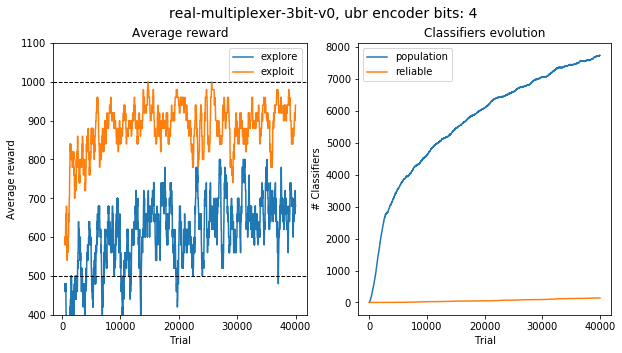

In [18]:
#%%time
evaluate(rmpx, encoder_bits=4, trials=40_000)

In [19]:
# %%time
# evaluate(rmpx, encoder_bits=5)

### 6-bit rMPX

In [20]:
rmpx6 = gym.make('real-multiplexer-6bit-v0')

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1, 'reward': 1000, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 5000, 'steps_in_trial': 1, 'reward': 1000, 'population': 2984, 'numerosity': 3877, 'reliable': 36}


CPU times: user 8min, sys: 546 ms, total: 8min
Wall time: 8min


([..O.|...O|.O..|..O.|.O..|.O..|O...	0	OOOO|OOOO|OOOO|OOOO|OOOO|OOOO|...O x 1 fitness: 40.13,
  .O..|O...|.O..|...O|.O..|...O|O...	0	OOOO|OOOO|OOOO|OOOO|OOOO|OOOO|...O x 1 fitness: 49.22,
  .O..|...O|.O..|O...|O...|O...|O...	0	OOOO|OOOO|OOOO|OOOO|OOOO|OOOO|...O x 1 fitness: 54.49,
  ...O|O...|...O|...O|O...|.O..|O...	0	OOOO|OOOO|OOOO|OOOO|OOOO|OOOO|...O x 1 fitness: 65.87,
  ...O|..O.|..O.|...O|...O|O...|O...	0	OOOO|OOOO|OOOO|OOOO|OOOO|OOOO|...O x 1 fitness: 59.95,
  ...O|O...|..O.|.O..|...O|...O|OOOO	0	OOOO|OOOO|OOOO|OOOO|OOOO|OOOO|OOOO x 1 fitness: 71.36,
  O...|...O|...O|O...|...O|O...|O...	0	OOOO|OOOO|OOOO|OOOO|OOOO|OOOO|...O x 1 fitness: 82.92,
  ..O.|..O.|..O.|.O..|O...|...O|OOOO	0	OOOO|OOOO|OOOO|OOOO|OOOO|OOOO|OOOO x 1 fitness: 90.97,
  .O..|..O.|..O.|...O|...O|O...|OOOO	0	OOOO|OOOO|OOOO|OOOO|OOOO|OOOO|OOOO x 1 fitness: 93.41,
  ..O.|..O.|O...|O...|...O|.O..|O...	0	OOOO|OOOO|OOOO|OOOO|OOOO|OOOO|...O x 1 fitness: 85.31,
  .O..|...O|...O|.O..|..O.|...O|O...	0	OOOO|OOOO|OOOO|OOOO|O

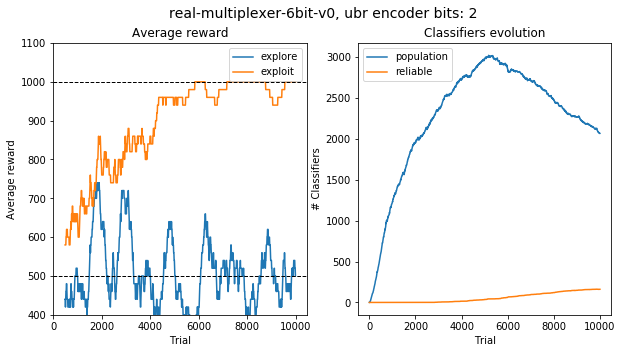

In [21]:
%%time
evaluate(rmpx6, encoder_bits=2, trials=10_000)

In [22]:
%%time
# evaluate(rmpx6, encoder_bits=2, trials=15_000)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs
